# NCS
## Loading basic libraries and testing the virtual environment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import sklearn
import seaborn as sns
#import tensorflow as tf
#import tensorflow_datasets as tfds
from sklearn.svm import  SVC
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from math import sqrt

In [2]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.2.


@author {Rayen Dhahri, Abdelrhman Abdelmooty, Ahmed Aziz Becheur,Bahaeddine Naili, Omar Tbeileh }

In [3]:
df = pd.read_csv("../dataset/NC_policing.csv")


In [4]:
print (df.head())
print (df.dtypes)

  state   stop_date driver_gender  driver_age driver_race_raw driver_race  \
0    NC  2000-07-31             M        23.0             W N       White   
1    NC  2000-07-31             F        29.0             W N       White   
2    NC  2000-07-31             F        49.0             B N       Black   
3    NC  2000-07-31             M        29.0             B N       Black   
4    NC  2000-07-31             M        24.0             U H    Hispanic   

  violation          search_type  contraband_found stop_outcome  \
0  Speeding  No Search Conducted             False       Arrest   
1  Speeding  No Search Conducted             False       Arrest   
2  Speeding  No Search Conducted             False       Arrest   
3  Speeding  No Search Conducted             False       Arrest   
4  Speeding  No Search Conducted             False       Arrest   

          search_basis  officer_id drugs_related_stop district  
0  No Search Conducted       10606                NaN       E3  
1  N

### Inspecting ethnicities and their frequencies

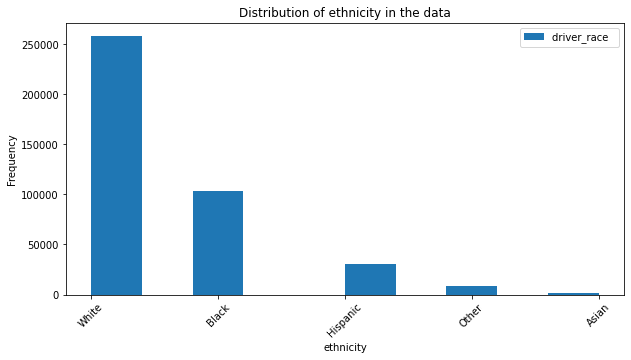

Black :  102919
White :  258525
Hispanic: 30715
Other:  8153
Asian:  1775


In [5]:
# Presence of races 
plt.figure(figsize=(10,5))
plt.hist(df['driver_race'], label='driver_race  ')
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('ethnicity')
plt.xticks(rotation=45)
plt.title("Distribution of ethnicity in the data")
plt.show()
print ("Black : ",df.loc[df['driver_race']=='Black','driver_race'].count())
print ("White : ",df.loc[df['driver_race']=='White','driver_race'].count())
print ("Hispanic:",df.loc[df['driver_race']=='Hispanic','driver_race'].count())
print ("Other: ",df.loc[df['driver_race']=='Other','driver_race'].count())
print ("Asian: ",df.loc[df['driver_race']=='Asian','driver_race'].count())

## Checking stop outcome for a race based on overall 
This will play a role afterwards to check for the fairness of the prediction model. We can see that the dataset is sensitive to the race .

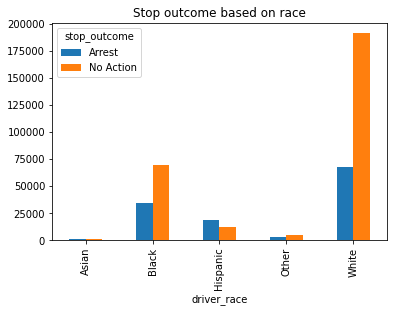

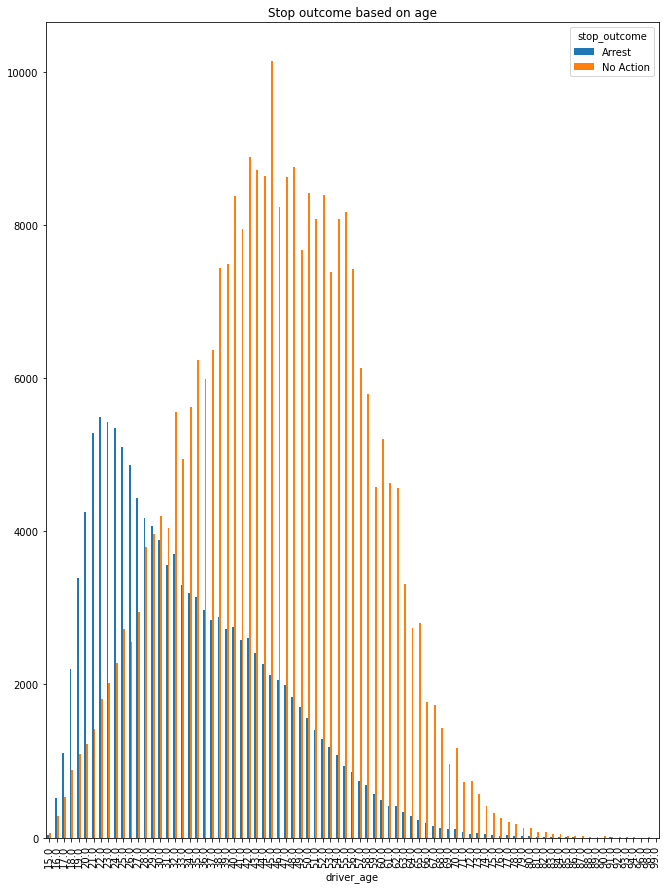

In [6]:
df_race = df[['driver_race','stop_outcome']]
df_race = df.groupby(['driver_race','stop_outcome']).size().unstack(fill_value=0)
df_race.plot.bar(title='Stop outcome based on race')
# The graph is crambled but on purpose plotted with all value to see stop progression based on age that can give us a hint on fairness
df_age = df[['driver_age','stop_outcome']]
df_age= df.groupby(['driver_age','stop_outcome']).size().unstack(fill_value=0)
pltfig = df_age.plot.bar(title='Stop outcome based on age',figsize=(11,15))
fig = pltfig.get_figure()
fig.savefig("basedonage.png")

## Cleaning the Dataset
In this step we try to check for corrupterd and drop irrelevant data.
As the state is a static input that is the same for all people and the driver_race_raw is contained

In [7]:
y= df['stop_outcome']

In [8]:
# Clenaning the dataset by checking for missing data
print(df.isna().sum())
# additional reason to drop drug related stop added to the huge ammount of missing data is the high corroleation between drug related stop
# and contraband found
le = LabelEncoder()
drug_dum = le.fit_transform(df['drugs_related_stop'])
contra = le.fit_transform(df['contraband_found'])
# printing the corroleation between both features
corr_cont = np.corrcoef(drug_dum,contra)
print(corr_cont)

state                      0
stop_date                  0
driver_gender              0
driver_age                91
driver_race_raw            0
driver_race                0
violation                  0
search_type                0
contraband_found           0
stop_outcome               0
search_basis               0
officer_id                 0
drugs_related_stop    397708
district                  38
dtype: int64
[[ 1.         -0.80608177]
 [-0.80608177  1.        ]]


In [9]:
X= df.drop(columns=['state','driver_race_raw','stop_date','stop_outcome'])
X= X.drop(columns=['drugs_related_stop'],axis=1)

In [10]:
X["driver_age"].fillna(X["driver_age"].mean(), inplace = True) 

# Encoding the features 
For meaningful encoding by having 1:True for arrested and 0 for not arrested,we seperate the encoding of the target

In [11]:
Man_enc = {"No Action": 0, "Arrest":1}
y=y.replace(Man_enc)
y

0         1
1         1
2         1
3         1
4         1
         ..
402082    1
402083    1
402084    1
402085    1
402086    1
Name: stop_outcome, Length: 402087, dtype: int64

In [12]:
col= ["driver_gender","driver_race","violation","search_type","contraband_found",
      "search_basis","district"]
X_encoded = X
X_encoded[col]=X_encoded[col].apply(lambda col: le.fit_transform(col))
X_encoded.head()


,driver_gender,driver_age,driver_race,violation,search_type,contraband_found,search_basis,officer_id,district
0,1,23.0,4,6,2,0,18,10606,34
1,0,29.0,4,6,2,0,18,10606,34
2,0,49.0,1,6,2,0,18,10606,34
3,1,29.0,1,6,2,0,18,10606,34
4,1,24.0,2,6,2,0,18,10606,34


## Feature corrolation 
Here we would like to search for the corroleation between features as a step that might helping reducing the ammount of features used in case 2 features are highly corroleated meaning that the feature is slightly irrelevant for the training as it is described in the other feature.
Previously, we saw that both contraband_found and drug related were highly corrolated,making it an additional reason to the missing data in drugs_related_stop to drop it. 
The corroleation of the remaining features shows that they can be used for the training.

                  driver_gender  driver_age  driver_race  violation  \
driver_gender          1.000000    0.145751    -0.015665  -0.087596   
driver_age             0.145751    1.000000     0.089606  -0.127407   
driver_race           -0.015665    0.089606     1.000000  -0.050814   
violation             -0.087596   -0.127407    -0.050814   1.000000   
search_type            0.044753    0.119433     0.029378  -0.025893   
contraband_found      -0.018942   -0.093173    -0.019921   0.056120   
search_basis           0.019321    0.046095     0.012444   0.000721   
officer_id             0.000873   -0.000464     0.000656   0.002207   
district               0.033567    0.041988     0.116688  -0.035441   

                  search_type  contraband_found  search_basis  officer_id  \
driver_gender        0.044753         -0.018942      0.019321    0.000873   
driver_age           0.119433         -0.093173      0.046095   -0.000464   
driver_race          0.029378         -0.019921      0.012

Text(0.5, 1.0, 'Correlation between features')

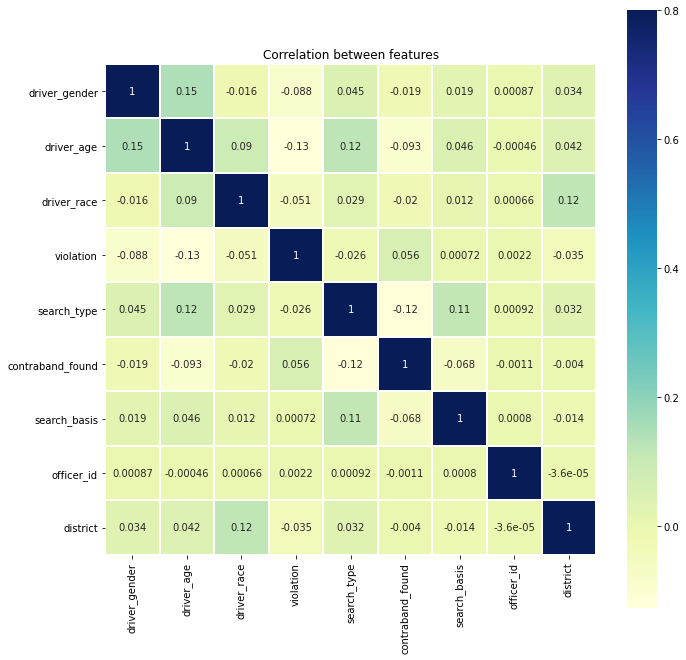

In [13]:
corr = X_encoded.corr()
print(X_encoded.corr())
plt.figure(figsize=[11,11])
sns.heatmap(corr,vmax=.8, linewidths=0.01,
           square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features')

In [14]:
X= X_encoded

In [15]:
X.head()

,driver_gender,driver_age,driver_race,violation,search_type,contraband_found,search_basis,officer_id,district
0,1,23.0,4,6,2,0,18,10606,34
1,0,29.0,4,6,2,0,18,10606,34
2,0,49.0,1,6,2,0,18,10606,34
3,1,29.0,1,6,2,0,18,10606,34
4,1,24.0,2,6,2,0,18,10606,34


In [16]:
# checking the types of the data
print(X.isna().sum())
print(df.info())

driver_gender       0
driver_age          0
driver_race         0
violation           0
search_type         0
contraband_found    0
search_basis        0
officer_id          0
district            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402087 entries, 0 to 402086
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   state               402087 non-null  object 
 1   stop_date           402087 non-null  object 
 2   driver_gender       402087 non-null  object 
 3   driver_age          401996 non-null  float64
 4   driver_race_raw     402087 non-null  object 
 5   driver_race         402087 non-null  object 
 6   violation           402087 non-null  object 
 7   search_type         402087 non-null  object 
 8   contraband_found    402087 non-null  bool   
 9   stop_outcome        402087 non-null  object 
 10  search_basis        402087 non-null  object 
 11  officer_id          402

Model

In [17]:
from sklearn.model_selection import train_test_split
X= X.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=10) 
X.dtypes

driver_gender       int32
driver_age          int32
driver_race         int32
violation           int32
search_type         int32
contraband_found    int32
search_basis        int32
officer_id          int32
district            int32
dtype: object

In [18]:
# testing with knn this is not our binary classifiers
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)


<Figure size 432x288 with 0 Axes>

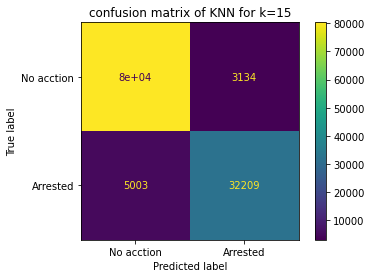

In [19]:
from sklearn.metrics import plot_confusion_matrix
# Plot the confusion matrix for the test set for the KNN classifier
plt.figure()
plot_confusion_matrix(knn, X_test, y_test,display_labels=['No acction','Arrested'])
plt.title('confusion matrix of KNN for k=15')
plt.show()


In [20]:
#first classifier without pca (no need for compression)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
num_splits = 10
#kfold = KFold(n_splits=num_splits, random_state=200, shuffle=True)

max_comp = X.shape[1]
param_grid = { 'n_neighbors':[5,10,15]}

#pipeline = Pipeline(steps=[('scaler',StandardScaler()), ('estimator', KNeighborsClassifier())])
search = GridSearchCV(KNeighborsClassifier(),param_grid, n_jobs=-1, cv=5, scoring='accuracy', return_train_score=True)
search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 15]}, return_train_score=True,
             scoring='accuracy')

In [21]:
print("accuracy" ,search.best_score_)
print(search.best_params_)

accuracy 0.9400056846443544
{'n_neighbors': 5}


[[80506  2909]
 [ 4020 33192]]


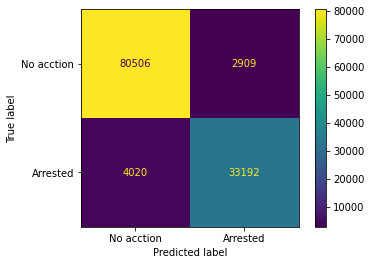

In [22]:
best_estimator = search.best_estimator_
y_pred = best_estimator.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print (cm)
plot_confusion_matrix(search, X_test, y_test,display_labels=['No acction','Arrested'])  

Ploting precision recall curve
Might be a hint for an unbalanced classification

PR AUC: 0.959


<ipython-input-23-ff8bb6a56352>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


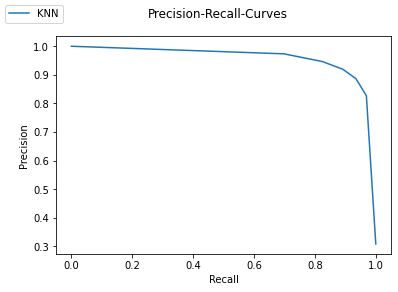

In [23]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
precision, recall, thresholds = precision_recall_curve(y_test, search.predict_proba(X_test)[:, 1])
fig = plt.figure()
fig.suptitle('Precision-Recall-Curves')
ax = fig.add_subplot(111)
plt.plot(recall, precision, label='KNN')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
fig.legend(loc=2)
fig.show()
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)


In [24]:
print(thresholds)

[0.  0.2 0.4 0.6 0.8 1. ]


<ipython-input-25-3bb1c19485f1>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 1], [0, 1], 'k--',color='blue')


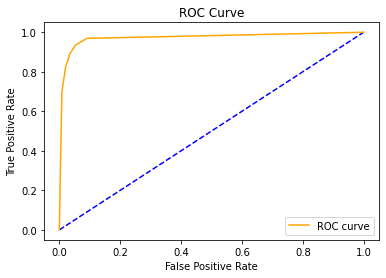

In [25]:
# Plot roc knn
from sklearn.metrics import roc_curve
y_pred_prob = search.best_estimator_.predict_proba(X_test)[:,1]
fprc, tprc, thresholds = roc_curve(y_test, y_pred_prob)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], 'k--',color='blue')
ax.plot(fprc, tprc,label='ROC curve',color='orange')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc=4)
plt.show()


# Fairness metrics
Here we define our fairness metrics: seperation, sufficiency and independence that will called later on call after the training. 
These metrics are defined:
Independence : $\mathbb{P}(R=1|A=a) = \mathbb{P}(R=1|A=b)$ can be expressed as $\large\frac{TP_{A=a}+FP_{A=a}}{\# \ Group\ a}\overset{!}{=}\frac{TP_{A=b}+FP_{A=b}}{\# \ Group\ b}$
Seperation : $\mathbb{P}(R=1|Y=1, A=a) = \mathbb{P}(R=1|Y=1, A=b)$ and $\mathbb{P}(R=1|Y=0, A=a) = \mathbb{P}(R=1|Y=0, A=b)$ can be expressed as $\large\frac{TP_{A=a}}{TP_{A=a}+FP_{A=a}}\overset{!}{=}\frac{TP_{A=b}}{TP_{A=b}+FP_{A=b}}$

In [26]:

def separation(tn, fp, fn, tp):
   
    Y_0 = tn / (tn + fn)
    Y_1 = tp / (tp + fp)
  
    return Y_1, Y_0

def sufficiency(tn, fp, fn, tp):
    R_1 = tp / (tp + fn)
    R_0 = fp / (fp + tn)
    return R_1, R_0
# switched tp and tn 
def independence (tp,tn,fn,fp ):
    return (tp + fp) / (tn + fp + fn + tp)



In [27]:
sep = separation(tn,fp,fn,tp)
suf = sufficiency(tn, fp, fn, tp)
ind = independence (tp,tn,fn,fp )

In [28]:
print (sep)
print(suf)
print(ind)

(0.9194205146671838, 0.9524406691432222)
(0.891970332150919, 0.034873823652820234)
0.2992779394331286


# Second Classifier
Here we picked a logicsticRegression and we try to see if it will be a better fit than the Kneighbourclassifier.

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn import decomposition
std_slc = StandardScaler()
logistic_Reg = LogisticRegression()
pca = decomposition.PCA()
pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('logistic_Reg', logistic_Reg)])
#n_components = list(range(1,X.shape[1]))
C = np.logspace(-4, 4, 2)
parameters = dict(#pca__n_components=n_components,
                  logistic_Reg__C=C,
                  )
search_lin = GridSearchCV(pipe,parameters, cv=5, scoring='accuracy', return_train_score=True)
search_lin.fit(X_train,y_train)
scores = cross_val_score (search_lin,X_train,y_train,cv=10)
print(scores.mean())


0.8111134797129255


In [30]:
print(search_lin.best_params_)
print(search_lin.best_score_)

{'logistic_Reg__C': 10000.0}
0.8111809848646343


In [31]:
best_estimator = search.best_estimator_
y_pred_lin = search_lin.best_estimator_.predict(X_test)

[[77714  5701]
 [17039 20173]]


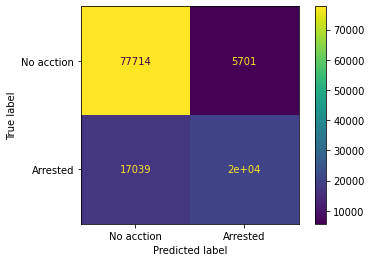

In [32]:
cm = confusion_matrix(y_test, y_pred_lin)
tn, fp, fn, tp = cm.ravel()
plot_confusion_matrix(search_lin, X_test, y_test,display_labels=['No acction','Arrested'])  
print(cm)

<ipython-input-33-755bb2513c7c>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 1], [0, 1], 'k--',color='blue')


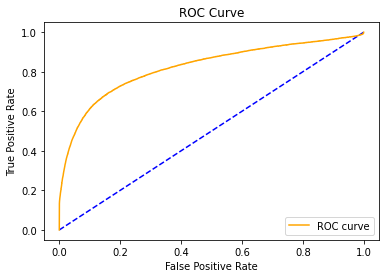

In [33]:
# Plot
from sklearn.metrics import roc_curve
y_pred_prob = search_lin.best_estimator_.predict_proba(X_test)[:,1]
fp, tp, thresholds = roc_curve(y_test, y_pred_prob)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], 'k--',color='blue')
ax.plot(fp, tp,label='ROC curve',color='orange')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc=4)
plt.show()

# Dummy Classifier
Here we would like to compare the performance of our classifier compared to a dummy classifier that predicts always not arrested.
For this, we use the DummyClassifier implemented by sklearn and we use " most frequent" as trategy as not arrested is the outcome of most
features

In [34]:
from sklearn.dummy import DummyClassifier
s ='most_frequent'

test_scores = []
dclf = DummyClassifier(strategy = s, random_state = 0)
dclf.fit(X_train, y_train)
score = dclf.score(X_test, y_test)
test_scores.append(score)
print (test_scores)

[0.6915118505807157]


In [35]:
df.loc[df['stop_outcome']=='No Action','stop_outcome'].count() # to check for the corecctness of the dummy classifier

278273

# Grouping different races

Here we group races together to see overall behaviour of our clasifier depending on each race 

In [36]:
# we could have extracted the feature and manually encoded it or inversed the encoded or plotting the same graph and identified the encoding
# however for practice reasons we try to determinate manually as a future skills to identify pattern in a dataset.
# creating groups
dic = {'4':'White','1':'Black','2':'Hispanic','3':'Other','0':'Asian'}
print ("encoded as 4 ",X.loc[X['driver_race']==4,'driver_race'].count()) # and comparing with the counts before encoding == White
print ("encoded as 2 ",X.loc[X['driver_race']==2,'driver_race'].count())# hispanic
print ("encoded as 3 ",X.loc[X['driver_race']==3,'driver_race'].count())# other
print ("encoded as 1 ",X.loc[X['driver_race']==1,'driver_race'].count())# black
print ("encoded as 0 ",X.loc[X['driver_race']==0,'driver_race'].count())#Asian
group_w = X_test['driver_race']==4
group_b = X_test['driver_race']==1
group_h = X_test['driver_race']==2

# Age group
group_age_sup = X_test['driver_age']>=30
group_age_inf = X_test['driver_age']<=30


encoded as 4  258525
encoded as 2  30715
encoded as 3  8153
encoded as 1  102919
encoded as 0  1775


In [37]:
# confusion matrix of black and hispanic
cm_w = confusion_matrix(y_test[group_w], y_pred[group_w])
cm_b = confusion_matrix(y_test[group_b], y_pred[group_b])
cm_h = confusion_matrix(y_test[group_h], y_pred[group_h])
cm_as = confusion_matrix(y_test[group_age_sup], y_pred[group_age_sup])
cm_ai = confusion_matrix(y_test[group_age_inf], y_pred[group_age_inf])

tn_b, fp_b, fn_b, tp_b = cm_b.ravel()
tn_h, fp_h, fn_h, tp_h = cm_h.ravel()
tn_w, fp_w, fn_w, tp_w = cm_w.ravel()
tn_as, fp_as, fn_as, tp_as = cm_as.ravel()
tn_ai, fp_ai, fn_ai, tp_ai = cm_ai.ravel()

<Figure size 432x288 with 0 Axes>

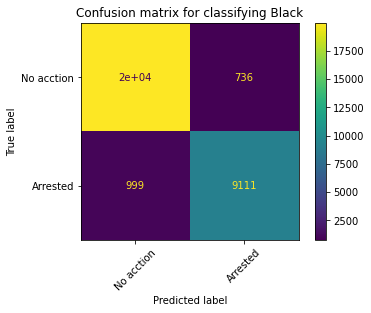

<Figure size 432x288 with 0 Axes>

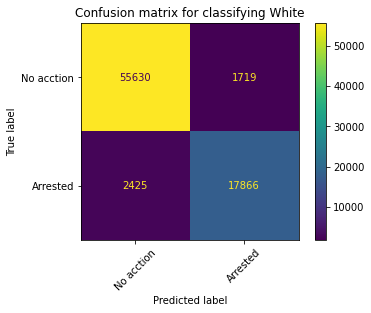

<Figure size 432x288 with 0 Axes>

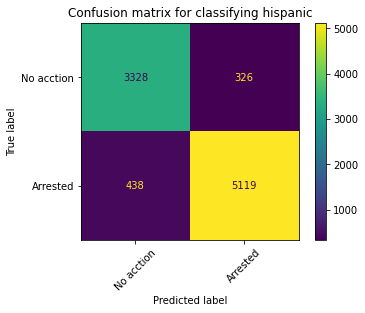

<Figure size 432x288 with 0 Axes>

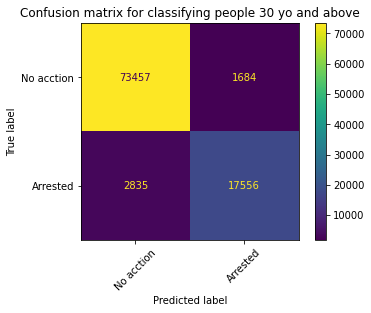

<Figure size 432x288 with 0 Axes>

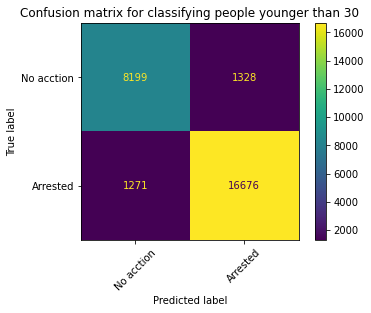

In [38]:
# ploting confusion matrixes for black, hispanic and white, above 30 and below 
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_b, display_labels=['No acction','Arrested'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion matrix for classifying Black")
plt.show()

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_w, display_labels=['No acction','Arrested'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion matrix for classifying White")
plt.show()

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_h, display_labels=['No acction','Arrested'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion matrix for classifying hispanic")
plt.show()

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_as, display_labels=['No acction','Arrested'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion matrix for classifying people 30 yo and above")
plt.show()

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ai, display_labels=['No acction','Arrested'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion matrix for classifying people younger than 30")
plt.show()

In [39]:
# calculating seperation, independence and sufficiency for each group  
#white
sep_w = separation(tn_w,fp_w,fn_w,tp_w)
suf_w = sufficiency(tn_w, fp_w, fn_w, tp_w)
ind_w = independence (tp_w,tn_w,fn_w,fp_w )
#Black 
sep_b = separation(tn_b,fp_b,fn_b,tp_b)
suf_b = sufficiency(tn_b, fp_b, fn_b, tp_b)
ind_b = independence (tp_b,tn_b,fn_b,fp_b )
#Hispanic
sep_h = separation(tn_h,fp_h,fn_h,tp_h)
suf_h = sufficiency(tn_h, fp_h, fn_h, tp_h)
ind_h = independence (tp_h,tn_h,fn_h,fp_h )
#old
sep_as = separation(tn_as,fp_as,fn_as,tp_as)
suf_as = sufficiency(tn_as, fp_as, fn_as, tp_as)
ind_as = independence (tp_as,tn_as,fn_as,fp_as )
#young
sep_ai = separation(tn_ai,fp_ai,fn_ai,tp_ai)
suf_ai = sufficiency(tn_ai, fp_ai, fn_ai, tp_ai)
ind_ai = independence (tp_ai,tn_ai,fn_ai,fp_ai )
# printing
print("hispanic sep ",sep_h)
print("hispanic ind ",ind_h)
print("hispanic suf",suf_h)
print ("------------------------")
print("black sep ",sep_b)
print("black ind ",ind_b)
print("black suf",suf_b)
print ("------------------------")
print("White sep ",sep_w)
print("White ind ",ind_w)
print("White suf",suf_w)

print ("------------------------")
print("older than 30 sep ",sep_as)
print("older than 30 sep ",ind_as)
print("older suf",suf_as)

print ("------------------------")
print("younger than 30 sep ",sep_ai)
print("younger than 30 sep ",ind_ai)
print("younger than 30 suf",suf_ai)


hispanic sep  (0.9401285583103764, 0.8836962294211365)
hispanic ind  0.5911410270328955
hispanic suf (0.9211804930718013, 0.08921729611384784)
------------------------
black sep  (0.9252564232761247, 0.9523241385892909)
black ind  0.3196974124216746
black suf (0.901186943620178, 0.035571021216954234)
------------------------
White sep  (0.9122287464896605, 0.9582292653518215)
White ind  0.2522539927872231
White suf (0.8804888866985363, 0.029974367469354304)
------------------------
older than 30 sep  (0.9124740124740125, 0.9628401405127668)
older than 30 sep  0.20139848427751958
older suf (0.8609680741503605, 0.022411200276812926)
------------------------
younger than 30 sep  (0.926238613641413, 0.8657866948257655)
younger than 30 sep  0.6553104753585208
younger than 30 suf (0.9291803644063075, 0.13939330324341345)


# Fairness Tuning 
Here we chose the first KNeighborsClassifier and try to make it more performant and fairer by excluding some data.
## Driver race
first we try to check the model's performance after droping the driver race

Not only the race is affecting the stop outcome fairness but first we check with the driver race
This section and lines of code are not the only features that will be dropped

In [40]:
X_train_fair = X_train.drop('driver_race',axis=1)
X_test_fair = X_test.drop('driver_race', axis=1)

In [41]:
X_train_fair.head()


,driver_gender,driver_age,violation,search_type,contraband_found,search_basis,officer_id,district
340800,1,41,2,2,0,18,10772,13
184497,1,20,0,2,0,18,11704,22
228164,0,21,2,2,0,18,11647,14
223998,1,58,2,2,0,18,21350,13
141278,1,53,2,2,0,18,11069,30


In [42]:
search.fit(X_train_fair,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 15]}, return_train_score=True,
             scoring='accuracy')

In [43]:
y_pred_fair = search.best_estimator_.predict(X_test_fair)

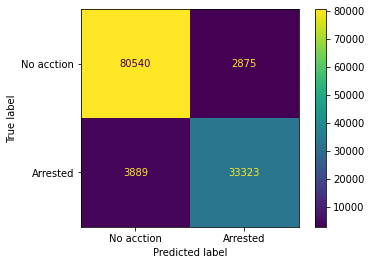

In [44]:
cm = confusion_matrix(y_test, y_pred_fair)
tn, fp, fn, tp = cm.ravel()
plot_confusion_matrix(search, X_test_fair, y_test,display_labels=['No acction','Arrested']) 

In [45]:
print(search.best_score_)

0.9411923541533433


## Checking how is the fairness depending on groups 

Behavior of the classifier depending on the race and age

In [46]:
X_train_fair = X_train.drop(columns=['driver_race','driver_age'],axis=1)
X_test_fair = X_test.drop(columns=['driver_race','driver_age'], axis=1)

In [47]:
search.fit(X_train_fair,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 15]}, return_train_score=True,
             scoring='accuracy')

In [48]:
y_pred_fair = search.best_estimator_.predict(X_test_fair)

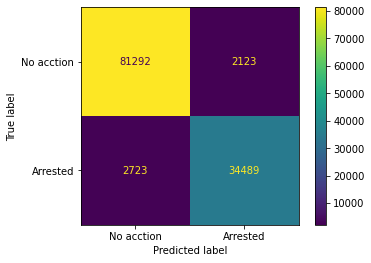

In [49]:
cm = confusion_matrix(y_test, y_pred_fair)
tn_, fp_, fn_, tp_ = cm.ravel()
plot_confusion_matrix(search, X_test_fair, y_test,display_labels=['No acction','Arrested']) 

In [50]:
print(search.best_score_)

0.9598593050522277


Behavior of the model overall after dropping sensitive data

In [51]:
sep_ = separation(tn_,fp_,fn_,tp_)
suf_ = sufficiency(tn_, fp_, fn_, tp_)
ind_ = independence (tp_,tn_,fn_,fp_ )

In [52]:
print (sep_)
print(suf_)
print(ind_)

(0.9420135474707746, 0.9675891209902994)
(0.9268246802106848, 0.025451057963196067)
0.30351413862568083


Model behavior on the groups

In [53]:

cm_wf = confusion_matrix(y_test[group_w], y_pred_fair[group_w])
cm_bf = confusion_matrix(y_test[group_b], y_pred_fair[group_b])
cm_hf = confusion_matrix(y_test[group_h], y_pred_fair[group_h])
cm_asf = confusion_matrix(y_test[group_age_sup], y_pred_fair[group_age_sup])
cm_aif = confusion_matrix(y_test[group_age_inf], y_pred_fair[group_age_inf])

tn_bf, fp_bf, fn_bf, tp_bf = cm_bf.ravel()
tn_hf, fp_hf, fn_hf, tp_hf = cm_hf.ravel()
tn_wf, fp_wf, fn_wf, tp_wf = cm_wf.ravel()
tn_asf, fp_asf, fn_asf, tp_asf = cm_asf.ravel()
tn_aif, fp_aif, fn_aif, tp_aif = cm_asf.ravel()

<Figure size 432x288 with 0 Axes>

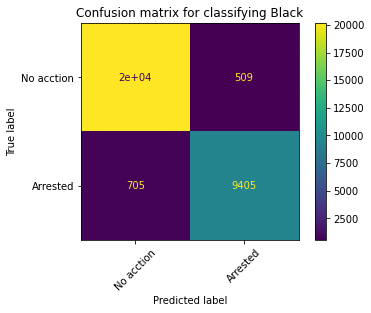

<Figure size 432x288 with 0 Axes>

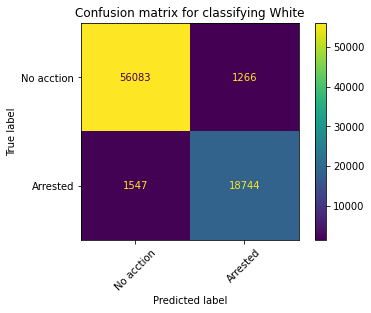

<Figure size 432x288 with 0 Axes>

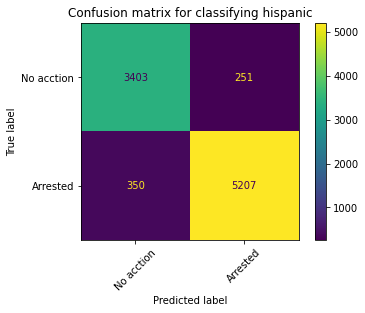

<Figure size 432x288 with 0 Axes>

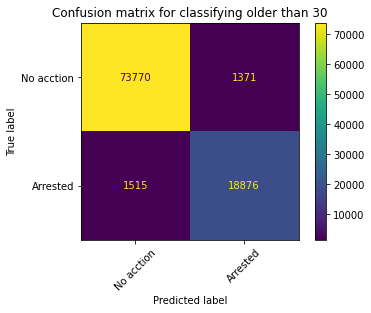

<Figure size 432x288 with 0 Axes>

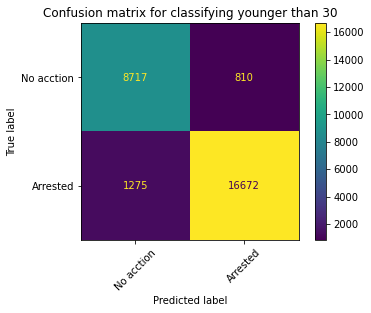

In [54]:
# ploting confusion matrixes for black, hispanic and white 
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bf, display_labels=['No acction','Arrested'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion matrix for classifying Black")
plt.show()

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_wf, display_labels=['No acction','Arrested'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion matrix for classifying White")
plt.show()

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_hf, display_labels=['No acction','Arrested'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion matrix for classifying hispanic")
plt.show()

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_asf, display_labels=['No acction','Arrested'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion matrix for classifying older than 30")
plt.show()

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_aif, display_labels=['No acction','Arrested'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion matrix for classifying younger than 30")
plt.show()

## Metrics after fairness tuning 


In [55]:
# calculating seperation, independence and sufficiency for each group  
#white
sep_wf = separation(tn_wf,fp_wf,fn_wf,tp_wf)
suf_wf = sufficiency(tn_wf, fp_wf, fn_wf, tp_wf)
ind_wf = independence (tp_wf,tn_wf,fn_wf,fp_wf )
#Black 
sep_bf = separation(tn_bf,fp_bf,fn_bf,tp_bf)
suf_bf = sufficiency(tn_bf, fp_bf, fn_bf, tp_bf)
ind_bf = independence (tp_bf,tn_bf,fn_bf,fp_bf )
#Hispanic
sep_hf = separation(tn_hf,fp_hf,fn_hf,tp_hf)
suf_hf = sufficiency(tn_hf, fp_hf, fn_hf, tp_hf)
ind_hf = independence (tp_hf,tn_hf,fn_hf,fp_hf )
#older than 45
sep_asf = separation(tn_asf,fp_asf,fn_asf,tp_asf)
suf_asf = sufficiency(tn_asf, fp_asf, fn_asf, tp_asf)
ind_asf = independence (tp_asf,tn_asf,fn_asf,fp_asf )
# younger than 45
sep_aif = separation(tn_aif,fp_aif,fn_aif,tp_aif)
suf_aif = sufficiency(tn_aif, fp_aif, fn_aif, tp_aif)
ind_aif = independence (tp_aif,tn_aif,fn_aif,fp_aif )

# printing
print("After tunning hispanic sep  ",sep_hf)
print("After tunning hispanic ind ",ind_hf)
print("After tunning hispanic suf",suf_hf)
print ("------------------------")
print("After tunning black sep ",sep_bf)
print("After tunning black ind ",ind_bf)
print("After tunning black suf",suf_bf)
print ("------------------------")
print("After tunning White sep ",sep_wf)
print("After tunning White ind ",ind_wf)
print("After tunning White suf",suf_wf)
print ("------------------------")
print("After tunning older sep ",sep_wf)
print("After tunning older ind ",ind_wf)
print("After tunning older suf",suf_wf)
print ("------------------------")
print("After tunning younger sep ",sep_aif)
print("After tunning younger ind ",ind_aif)
print("After tunning younger suf",suf_aif)


After tunning hispanic sep   (0.9540124587761085, 0.9067412736477485)
After tunning hispanic ind  0.5925523830203018
After tunning hispanic suf (0.937016375742307, 0.06869184455391351)
------------------------
After tunning black sep  (0.9486584627799072, 0.9662469478623067)
After tunning black ind  0.3218726664718678
After tunning black suf (0.93026706231454, 0.024600067662268618)
------------------------
After tunning White sep  (0.9367316341829085, 0.9731563421828908)
After tunning White ind  0.25772797527047914
After tunning White suf (0.9237593021536642, 0.02207536312751748)
------------------------
After tunning older sep  (0.9367316341829085, 0.9731563421828908)
After tunning older ind  0.25772797527047914
After tunning older suf (0.9237593021536642, 0.02207536312751748)
------------------------
After tunning younger sep  (0.9322862646317973, 0.9798764694162184)
After tunning younger ind  0.2119394548423565
After tunning younger suf (0.9257025158158011, 0.01824569808759532)


# Setting thresholds 

the following code cell is a draft that will not be used later on

In [56]:
# optimal threshes
from sklearn.metrics import roc_curve
fprc_b, tprc_b, thresholds_b = roc_curve(y_test[group_b], y_pred_prob[group_b])
fprc_h, tprc_h, thresholds_h = roc_curve(y_test[group_h], y_pred_prob[group_h])
fprc_as, tprc_as, thresholds_as = roc_curve(y_test[group_age_sup], y_pred_prob[group_age_sup])
index_b = np.argmax(tprc_b - fprc_b)
index_h = np.argmax(tprc_h - fprc_h)
index_as = np.argmax(tprc_as - fprc_as)
print("optimal thresh black overall", thresholds_b[index_b])
print("optimal thresh hispanic ",thresholds_h[index_h])
print("optimal thresh age ",thresholds_as[index_as])
# optimal thresh
index = np.argmax(tprc - fprc)
print("optimal thresh overall", thresholds[index])


optimal thresh black overall 0.4304955880794981
optimal thresh hispanic  0.41237350830167396
optimal thresh age  0.30825733958283563
optimal thresh overall 0.9999325521301293


We set a thresholds by creating grouping some features from the race and the age 

In [57]:
# to avaoid chaining warnings 
X_thresh_train = X_train.copy()
X_thresh_test = X_test.copy()
# Grouping races we do remember that the encoding is so  dic = {'4':'White','1':'Black','2':'Hispanic','3':'Other','0':'Asian'}
# We combine asian hispânic and black and give it a static attribute 0
# for the training
X_thresh_train.loc[X_thresh_train['driver_race'] <3, 'driver_race'] = 0
X_thresh_train.loc[X_thresh_train['driver_race'] >2, 'driver_race'] = 1
# for the testing
X_thresh_test.loc[X_thresh_test['driver_race'] <3, 'driver_race'] = 0
X_thresh_test.loc[X_thresh_test['driver_race'] >2, 'driver_race'] = 1

# Grouping the driver_age above 30 and 30 or less 
# for the training
X_thresh_train.loc[X_thresh_train['driver_age'] >30, 'driver_age'] = 0
X_thresh_train.loc[X_thresh_train['driver_age'] <31, 'driver_age'] = 1
# for the testing
X_thresh_test.loc[X_thresh_test['driver_age'] <30, 'driver_age'] = 0
X_thresh_test.loc[X_thresh_test['driver_age'] <31, 'driver_age'] = 1 
print(X_thresh_train.head())

        driver_gender  driver_age  driver_race  violation  search_type  \
340800              1           1            0          2            2   
184497              1           1            1          0            2   
228164              0           1            1          2            2   
223998              1           1            0          2            2   
141278              1           1            0          2            2   

        contraband_found  search_basis  officer_id  district  
340800                 0            18       10772        13  
184497                 0            18       11704        22  
228164                 0            18       11647        14  
223998                 0            18       21350        13  
141278                 0            18       11069        30  


## Retraining the model with the threshholds 

In [58]:
search.fit(X_thresh_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 15]}, return_train_score=True,
             scoring='accuracy')

In [59]:
print(search.best_score_)
y_pred_thresh = search.best_estimator_.predict(X_thresh_test)


0.9596958715270375


Checking overall confusion matrix

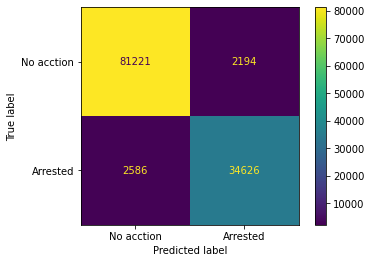

In [60]:
cm_thresh = confusion_matrix(y_test, y_pred_thresh)
tn_t, fp_t, fn_t, tp_t = cm.ravel()
plot_confusion_matrix(search, X_thresh_test, y_test,display_labels=['No acction','Arrested']) 

The overral tp tn fp and fn improved with these thresholds 

## Model performence with the threshold on the groups

In [61]:
# overall 
sep_t = separation(tn_t,fp_t,fn_t,tp_t)
suf_t = sufficiency(tn_t, fp_t, fn_t, tp_t)
ind_t = independence (tp_t,tn_t,fn_t,fp_t )

In [62]:
cm_wf_thresh = confusion_matrix(y_test[group_w], y_pred_thresh[group_w])
cm_bf_thresh = confusion_matrix(y_test[group_b], y_pred_thresh[group_b])
cm_hf_thresh = confusion_matrix(y_test[group_h], y_pred_thresh[group_h])
cm_asf_thresh = confusion_matrix(y_test[group_age_sup], y_pred_thresh[group_age_sup])
cm_aif_thresh = confusion_matrix(y_test[group_age_inf], y_pred_thresh[group_age_inf])

tn_bf_thresh, fp_bf_thresh, fn_bf_thresh, tp_bf_thresh = cm_bf_thresh.ravel()
tn_hf_thresh, fp_hf_thresh, fn_hf_thresh, tp_hf_thresh = cm_hf_thresh.ravel()
tn_wf_thresh, fp_wf_thresh, fn_wf_thresh, tp_wf_thresh = cm_wf_thresh.ravel()
tn_asf_thresh, fp_asf_thresh, fn_asf_thresh, tp_asf_thresh = cm_asf_thresh.ravel()
tn_aif_thresh, fp_aif_thresh, fn_aif_thresh, tp_aif_thresh = cm_asf_thresh.ravel()

<Figure size 432x288 with 0 Axes>

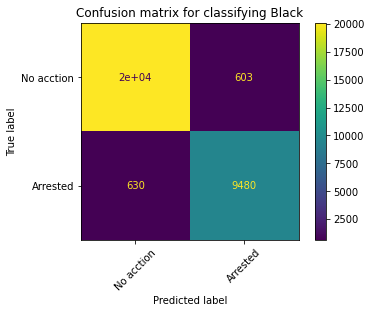

<Figure size 432x288 with 0 Axes>

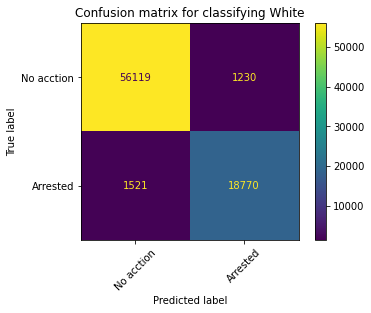

<Figure size 432x288 with 0 Axes>

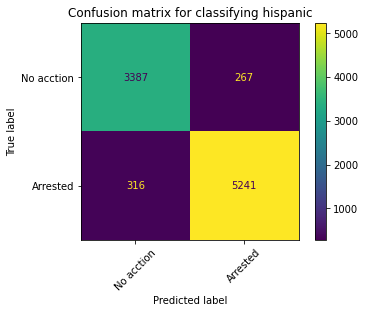

<Figure size 432x288 with 0 Axes>

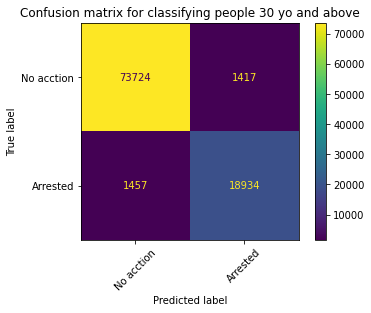

<Figure size 432x288 with 0 Axes>

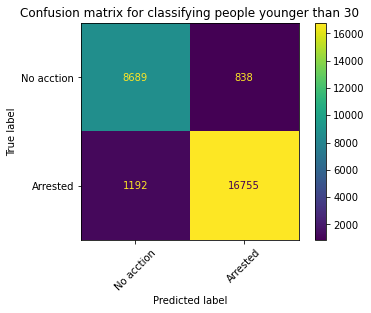

In [63]:
# after threshold
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bf_thresh, display_labels=['No acction','Arrested'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion matrix for classifying Black")
plt.show()

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_wf_thresh, display_labels=['No acction','Arrested'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion matrix for classifying White")
plt.show()

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_hf_thresh, display_labels=['No acction','Arrested'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion matrix for classifying hispanic")
plt.show()

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_asf_thresh, display_labels=['No acction','Arrested'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion matrix for classifying people 30 yo and above")
plt.show()

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_aif_thresh, display_labels=['No acction','Arrested'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion matrix for classifying people younger than 30")
plt.show()

In [64]:
# calculating seperation, independence and sufficiency for each group after thresh
#white
sep_wf_thresh = separation(tn_wf_thresh,fp_wf_thresh,fn_wf_thresh,tp_wf_thresh)
suf_wf_thresh = sufficiency(tn_wf_thresh, fp_wf_thresh, fn_wf_thresh, tp_wf_thresh)
ind_wf_thresh = independence (tp_wf_thresh,tn_wf_thresh,fn_wf_thresh,fp_wf_thresh )
#Black 
sep_bf_thresh = separation(tn_bf_thresh,fp_bf_thresh,fn_bf_thresh,tp_bf_thresh)
suf_bf_thresh = sufficiency(tn_bf_thresh, fp_bf_thresh, fn_bf_thresh, tp_bf_thresh)
ind_bf_thresh = independence (tp_bf_thresh,tn_bf_thresh,fn_bf_thresh,fp_bf_thresh )
#Hispanic
sep_hf_thresh = separation(tn_hf_thresh,fp_hf_thresh,fn_hf_thresh,tp_hf_thresh)
suf_hf_thresh = sufficiency(tn_hf_thresh, fp_hf_thresh, fn_hf_thresh, tp_hf_thresh)
ind_hf_thresh = independence (tp_hf_thresh,tn_hf_thresh,fn_hf_thresh,fp_hf_thresh )
#older than 45
sep_asf_thresh = separation(tn_asf_thresh,fp_asf_thresh,fn_asf_thresh,tp_asf_thresh)
suf_asf_thresh = sufficiency(tn_asf_thresh, fp_asf_thresh, fn_asf_thresh, tp_asf_thresh)
ind_asf_thresh = independence (tp_asf_thresh,tn_asf_thresh,fn_asf_thresh,fp_asf_thresh )
# younger than 45
sep_aif_thresh = separation(tn_aif_thresh,fp_aif_thresh,fn_aif_thresh,tp_aif_thresh)
suf_aif_thresh = sufficiency(tn_aif_thresh, fp_aif_thresh, fn_aif_thresh, tp_aif_thresh)
ind_aif_thresh = independence (tp_aif_thresh,tn_aif_thresh,fn_aif_thresh,fp_aif_thresh )

# Fairness metrics after theshholds

In [65]:
# printing
print("After setting thresh hispanic sep  ",sep_hf_thresh)
print("After setting thresh hispanic ind ",ind_hf_thresh)
print("After setting thresh hispanic suf",suf_hf_thresh)
print ("------------------------")
print("After setting thresh black sep ",sep_bf_thresh)
print("After setting thresh black ind ",ind_bf_thresh)
print("After setting thresh black suf",suf_bf_thresh)
print ("------------------------")
print("After setting thresh White sep ",sep_wf_thresh)
print("After setting thresh White ind ",ind_wf_thresh)
print("After setting thresh White suf",suf_wf_thresh)
print ("------------------------")
print("After setting thresh older sep ",sep_wf_thresh)
print("After setting thresh older ind ",ind_wf_thresh)
print("After setting thresh older suf",suf_wf_thresh)
print ("------------------------")
print("After setting thresh younger sep ",sep_aif_thresh)
print("After setting thresh younger ind ",ind_aif_thresh)
print("After setting thresh younger suf",suf_aif_thresh)


After setting thresh hispanic sep   (0.9515250544662309, 0.9146637861193627)
After setting thresh hispanic ind  0.597980675279557
After setting thresh hispanic suf (0.9431347849559114, 0.07307060755336617)
------------------------
After setting thresh black sep  (0.9401963701279381, 0.9695916594265855)
After setting thresh black ind  0.3273595013148924
After setting thresh black suf (0.9376854599406528, 0.029143105698129623)
------------------------
After setting thresh White sep  (0.9385, 0.9736120749479528)
After setting thresh White ind  0.2575991756826378
After setting thresh White suf (0.9250406584199892, 0.0214476276831331)
------------------------
After setting thresh older sep  (0.9385, 0.9736120749479528)
After setting thresh older ind  0.2575991756826378
After setting thresh older suf (0.9250406584199892, 0.0214476276831331)
------------------------
After setting thresh younger sep  (0.930371971893273, 0.980620103483593)
After setting thresh younger ind  0.21302809529791064
A